In [1]:
'''
Aim: get basic informations of cytokines
Author: Yike Xie
Date: Sep 2022
'''

'\nAim: get basic informations of cytokines\nAuthor: Yike Xie\nDate: Sep 2022\n'

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams

import seaborn as sns

In [6]:
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_cyto/'

In [4]:
res = pd.read_excel('/home/yike/phd/dengue/data/Luca_cyto_exp.xlsx', sheet_name='results', skiprows=[0])

# exclude VCAM1
cols = res.columns.tolist()
cols.remove('VCAM1')
res = res[cols]

res = res.set_index(['Condition', 'ID'])
res = res.replace(['<0.03', '<3.00', '<4.80'], 0)

res = res.astype('float').loc[['H', 'D', 'DWS', 'SD']]

###############################
ct_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/ct_pair.tsv', 
                      sep='\t', index_col=['cell_subtype', 'gene'])

cst_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cst_pair.tsv', 
                       sep='\t', index_col=['cell_subtype', 'gene'])

###############################
# load differential expressed cytokines according to Luca's experiment
exp_info = pd.read_excel('/home/yike/phd/dengue/data/Luca_cyto_exp.xlsx',
                        sheet_name='sig_cytos', skiprows=[0,1], index_col=0)

cts = ['Monocytes', 'conventional DCs', 'megakaryocytes', 'plasmacytoid DCs', 
       'NK cells', 'T cells', 'B cells', 'Plasmablasts',]

################################
# all_cytos = res.columns.tolist()
# sig_cytos = exp_info['Gene name'].tolist() # Luca's Man-Whitney test
# res = res[sig_cytos + [i for i in all_cytos if i not in sig_cytos]].loc[['H', 'D', 'DWS', 'SD']]

In [5]:
ct_pair[(ct_pair['med_pair'] >= 1) | (ct_pair['med_pair'] <= -1)].to_csv('/home/yike/phd/dengue/docs/paper_draft/additional_supplementary/DEGs_pairwise.tsv', sep='\t')

In [7]:
# pairwise comparison

if False:

    IDs_S = res.loc['SD'].index
    IDs_NS = res.loc['D'].index

    log2_fc = []
    for ID_S in IDs_S:
        avg_S = np.array(res.loc['SD', ID_S])
        for ID_NS in IDs_NS:
            avg_NS = np.array(res.loc['D', ID_NS])

            log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))

    log2_fc = np.asarray(log2_fc)

    med_pair = np.median(log2_fc, axis=0)
    pos_fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]
    neg_fra_pair = [len(log2_fc[:, i][log2_fc[:, i] < 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

    pair = pd.DataFrame([], index=res.columns)
    pair['med_pair'] = med_pair
    pair['fra_pair'] = pos_fra_pair
    pair['neg_fra_pair'] = neg_fra_pair

    #############################
    from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

    ###########################
    # Man-whitney U test
    stats_u = []
    pvalue_u = []

    for gene in res.columns:

        if ( res.loc['D'][gene].tolist() == res.loc['SD'][gene].tolist() ) == True: 
            s, p = 'N/A', 1
            stats_u.append(s)
            pvalue_u.append(p)
            continue

        s, p = mannwhitneyu(res.loc['D'][gene].tolist(), res.loc['SD'][gene].tolist(), alternative='two-sided',)
        stats_u.append(s)
        pvalue_u.append(p)

    pair['statistic_U'] = stats_u
    pair['pvalue_U'] = pvalue_u

    pair['avg_D'] = res.loc['D'].mean()
    pair['avg_SD'] = res.loc['SD'].mean()

    pair = pair.sort_values(['med_pair', 'avg_SD'], ascending=False)

    pair.index.name = 'gene'
    pair['log2_fold_change'] = (np.log2(res[pair.index].loc['SD'].mean(axis=0) + 0.1) - 
                                np.log2(res[pair.index].loc['D'].mean(axis=0) + 0.1))
    pair.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/cyto_pair.tsv', 
                sep='\t')

##########################
pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/cyto_pair.tsv', 
            sep='\t', index_col='gene')
sig_cytos = pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD']).index

In [8]:
def data_show(pair, res, pvalue, cds):
    
    idx_ks = pair[pair[pvalue] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index
    idx_not = [idx for idx in pair.index if idx not in idx_ks]
    idx_ks_rest = pair.loc[idx_not].sort_values(['med_pair', 'avg_SD'], ascending=False).index

    ks_data = np.log10(res[idx_ks].loc[cds].reset_index().set_index('ID')[
        res[idx_ks].loc[cds].reset_index().set_index('ID').columns[1:]] + 0.1)

    all_data_ks = np.log10(res[idx_ks.tolist() + idx_ks_rest.tolist()].loc[cds].reset_index().set_index('ID')[
        res[idx_ks.tolist() + idx_ks_rest.tolist()].loc[cds].reset_index().set_index('ID').columns[1:]] + 0.1)
    
    return all_data_ks

def heatmap(res_data, row_colors, title=False):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    cmap = sns.color_palette("vlag", as_cmap=True)

    g = sns.clustermap(res_data.T, col_colors=row_colors, col_cluster=False, row_cluster=False,
                       cbar_kws={'label':'Concentration', 'shrink': 0.1},
                       figsize=[2 + 0.5 * res_data.shape[0], 5 + 0.5 * res_data.shape[1]], cmap=cmap, 
                       cbar_pos=(1, 0.1, .03, .2), vmin=-1, vmax=6.5,
                       dendrogram_ratio=0.01, colors_ratio=0.01,)
    
    g.ax_heatmap.set_xlabel(None)
    g.ax_cbar.set_yticks([-1, np.log10(1.1),
                      np.log10(10 + .1), np.log10(10e2 + .1),
                      np.log10(10e3 + .1), np.log10(10e4 + .1), 
                      np.log10(10e5 + .1), np.log10(10e6 + .1),
                     ])
    g.ax_cbar.set_yticklabels([0, '1', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
    
    g.fig.tight_layout()
    if title is not False:
        g.fig.savefig(save_figures + 'heatmap_' + title + '.png', bbox_inches='tight')
        g.fig.savefig(save_figures + 'heatmap_' + title + '.pdf', bbox_inches='tight')

In [9]:
colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)

U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])

<ipython-input-66-319ba14c62d7>:16: UserWarning: Use the colorbar set_ticks() method instead.
  g.ax_cbar.set_yticks([-1, np.log10(1.1),
<ipython-input-66-319ba14c62d7>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_cbar.set_yticklabels([0, '1', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
<ipython-input-66-319ba14c62d7>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


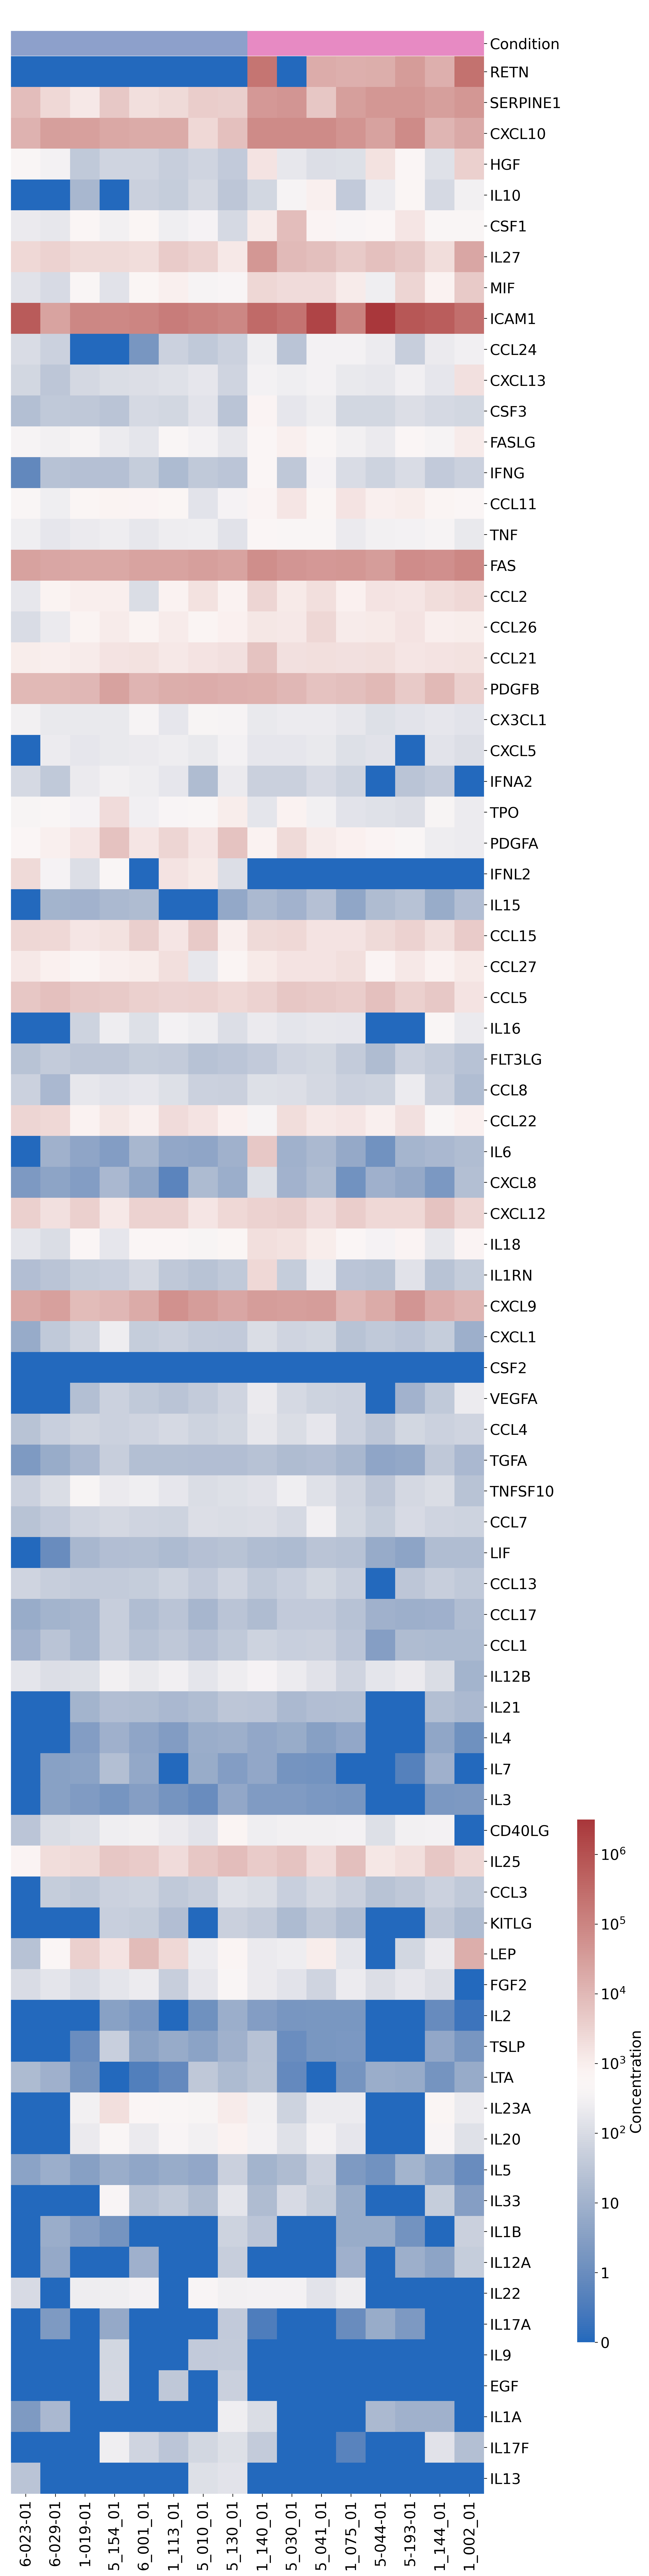

In [67]:
colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)

U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])
heatmap(U_data, row_colors, title='cyto_D_SD')

In [12]:
colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)

U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])
# heatmap(U_data, row_colors, title='cyto_D_SD')

<ipython-input-11-0bd474f17245>:30: UserWarning: Use the colorbar set_ticks() method instead.
  g.ax_cbar.set_yticks([-1, np.log10(1.1),
<ipython-input-11-0bd474f17245>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_cbar.set_yticklabels([0, '1', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
<ipython-input-11-0bd474f17245>:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


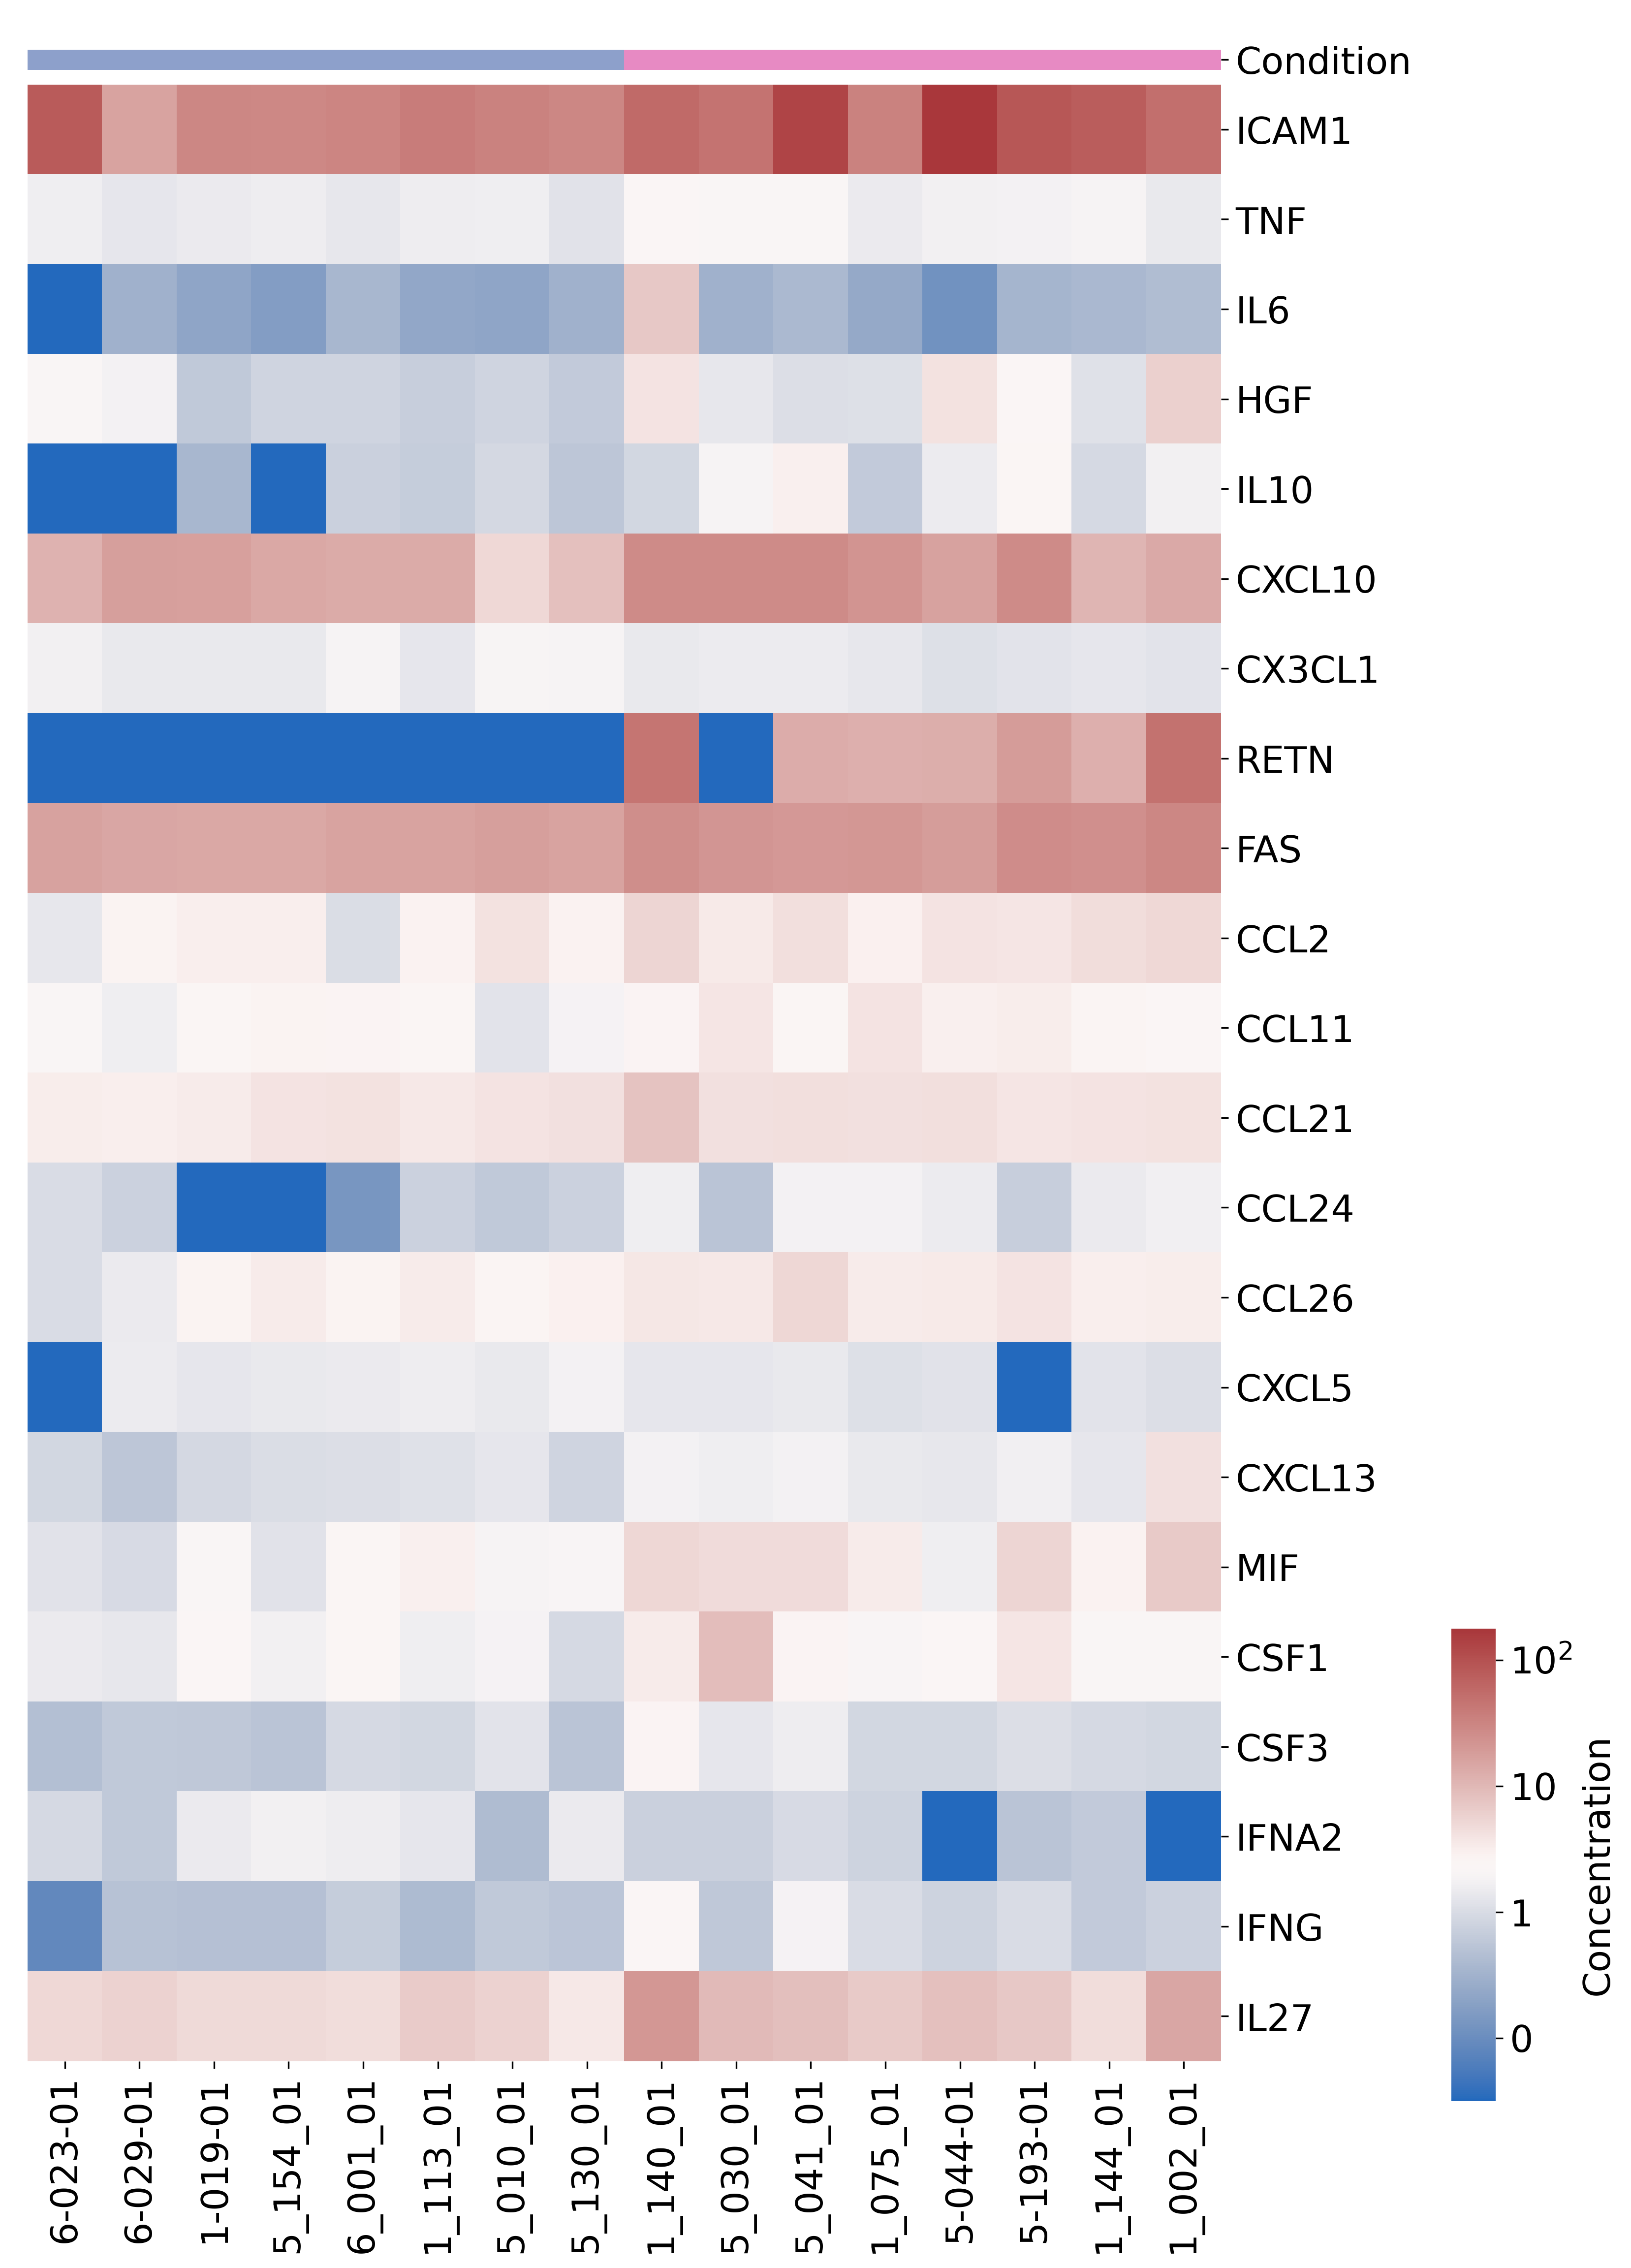

In [39]:
genes_show = [
    # indicators of endothelial dysfunction
    'ICAM1', 'TNF', 'IL6', #'VCAM1', 
    # protect ECs from dysfunction
    'HGF', 'IL10', 'CXCL10', 'CX3CL1', 
    # promotes ECs activation
    'RETN', 
    # cell apoptosis
    'FAS',
    # cell migration
    'CCL2','CCL11','CCL21','CCL24','CCL26','CXCL5','CXCL13', 'MIF',
    # 'leukocyte differentiation'
    'CSF1', 'CSF3', 'IFNA2','IFNG','IL27',
]

heatmap(U_data[genes_show], row_colors, title='grup_cyto_D_SD')

In [79]:
U_data_all = data_show(pair, res, 'pvalue_U', ['H', 'D', 'DWS','SD'])
heatmap(U_data_all, row_colors, title='cyto_all')

<ipython-input-72-19bbf4e96609>:16: UserWarning: Use the colorbar set_ticks() method instead.
  g.ax_cbar.set_yticks([-1, np.log10(1.1),
<ipython-input-72-19bbf4e96609>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_cbar.set_yticklabels([0, '1', '$10$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
<ipython-input-72-19bbf4e96609>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


In [5]:
def heatmap_cst(cst_pair, g_list, cst_order, vs_type='SD vs D', save_fd=False):
    #rcParams['figure.figsize']=(7, 14)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    df = cst_pair.reset_index().set_index('gene').loc[g_list][['cell_subtype', 'med_pair']]

    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), len(cst_order)]), columns=cst_order, index=g_list)

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col]['med_pair'][0]
            
    df_new = pd.DataFrame(np.clip(df_new.values, -1.5, 1.5), columns=df_new.columns, index=df_new.index)
    
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    
    g = sns.clustermap(df_new, col_cluster=False, row_cluster=False,
                       cmap=cmap, center=0, yticklabels=True, vmin=-1.5, vmax=1.5,
                       cbar_kws={'label': 'log2 fold change\n[%s]'%vs_type, 'shrink': .3},
                       cbar_pos=(0.99, 0.4, .02, .2), dendrogram_ratio=0.05, colors_ratio=0.01,
                       figsize=[1 + 0.5 * len(cst_order), 0.5 * len(g_list)])
    ax = g.ax_heatmap
    ax.set_ylabel(None)
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    if save_fd is not False:
        g.savefig(save_figures + save_fd, bbox_inches='tight')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


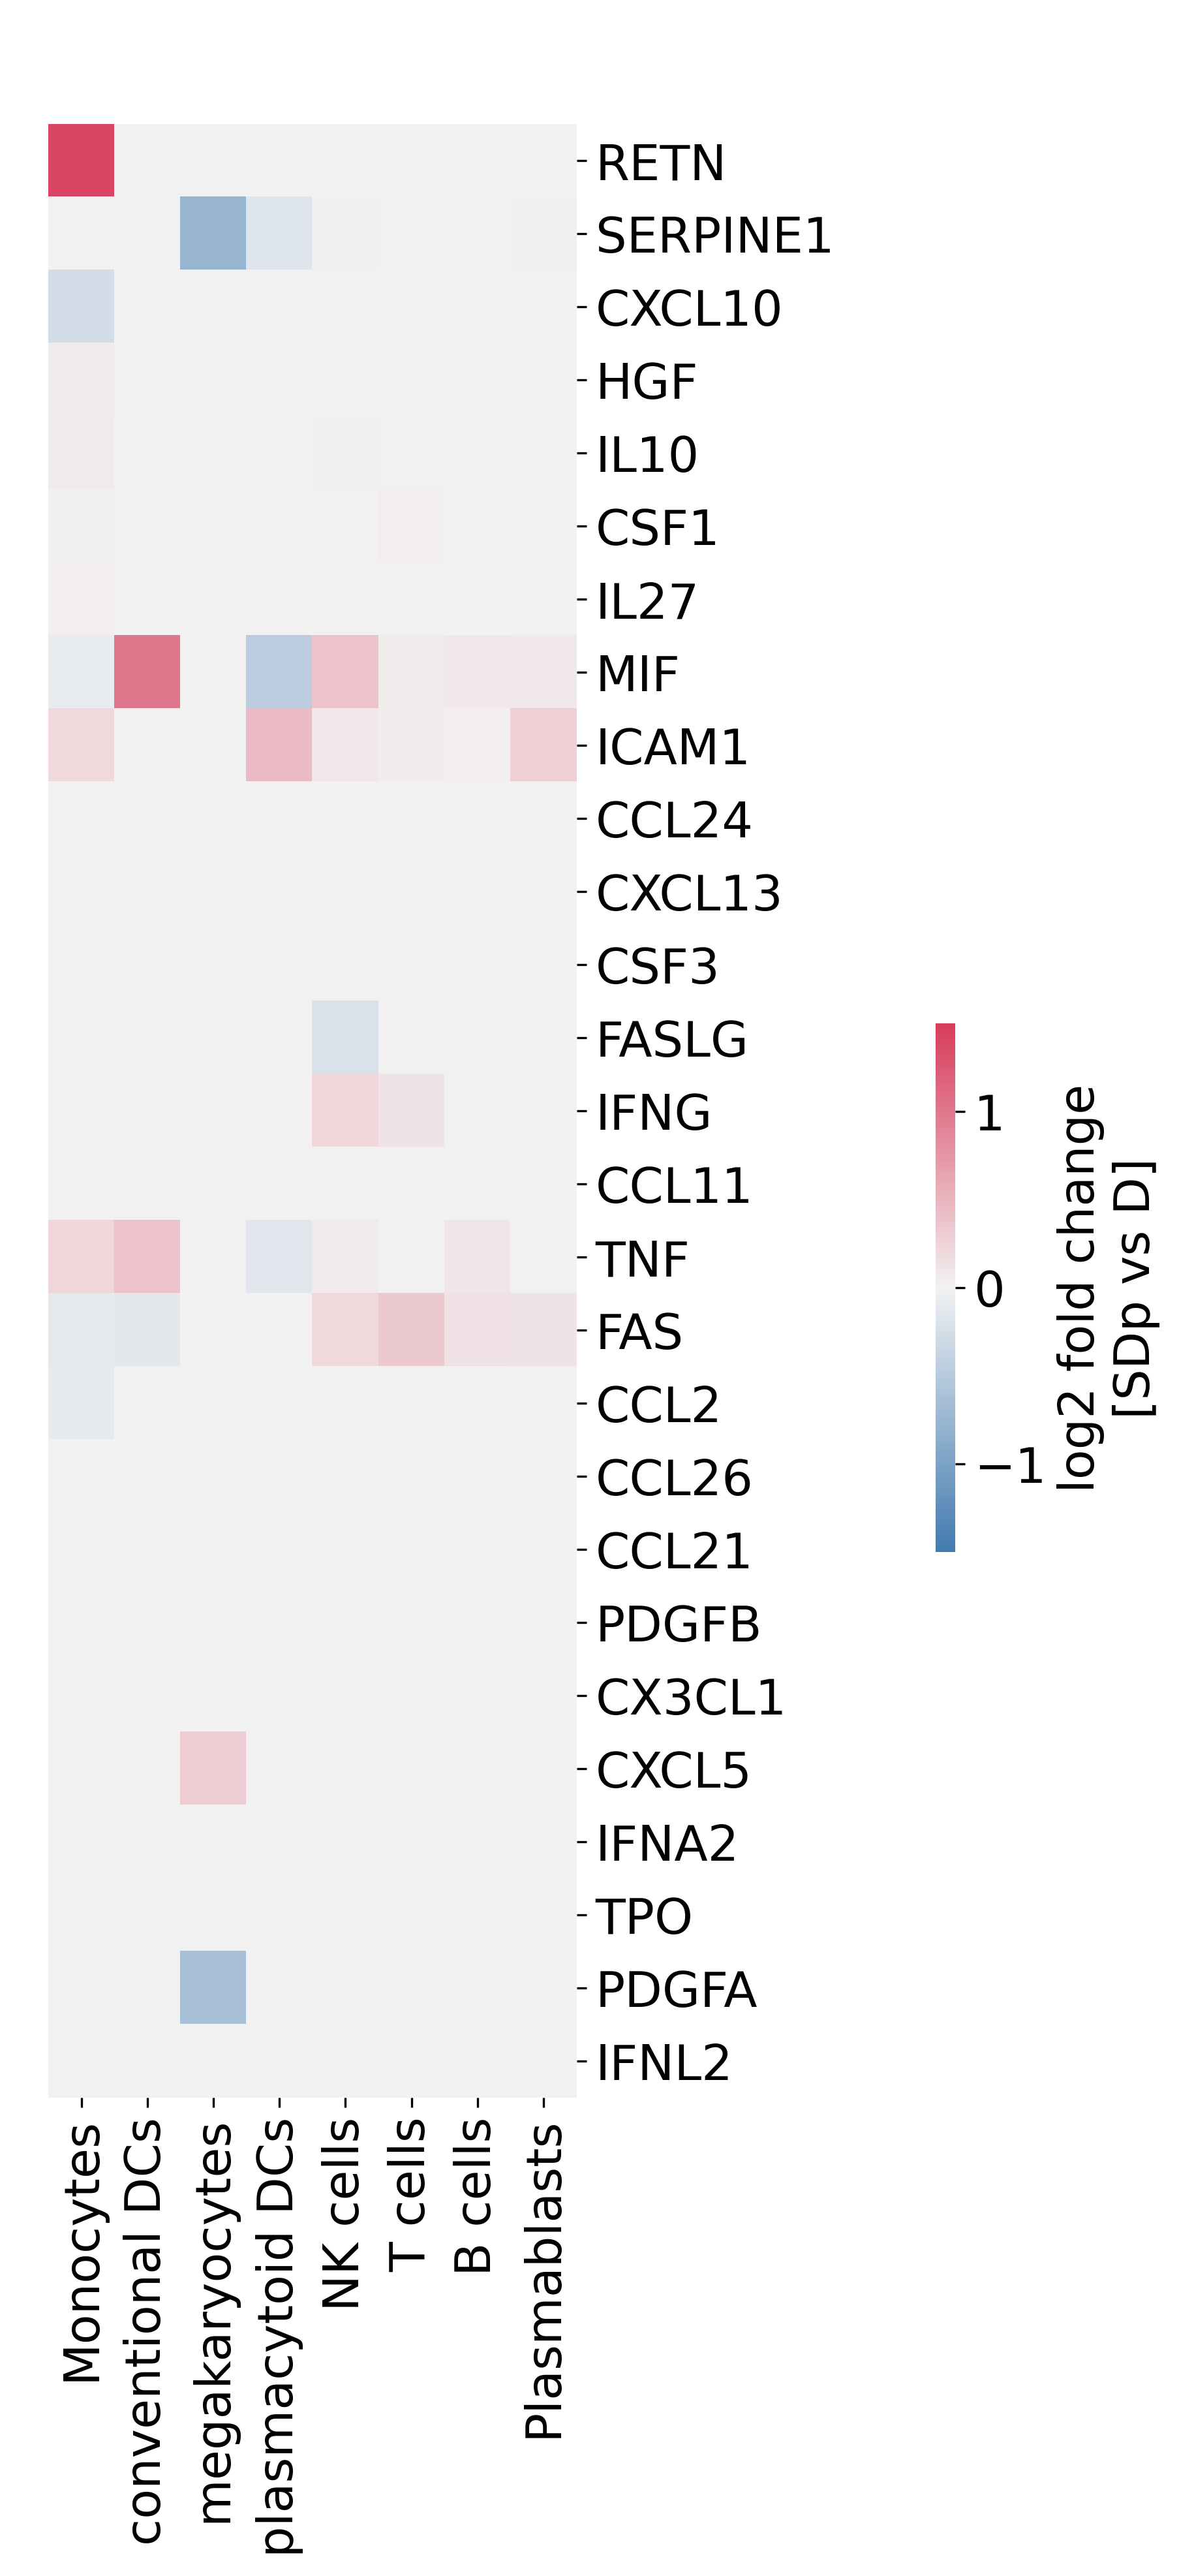

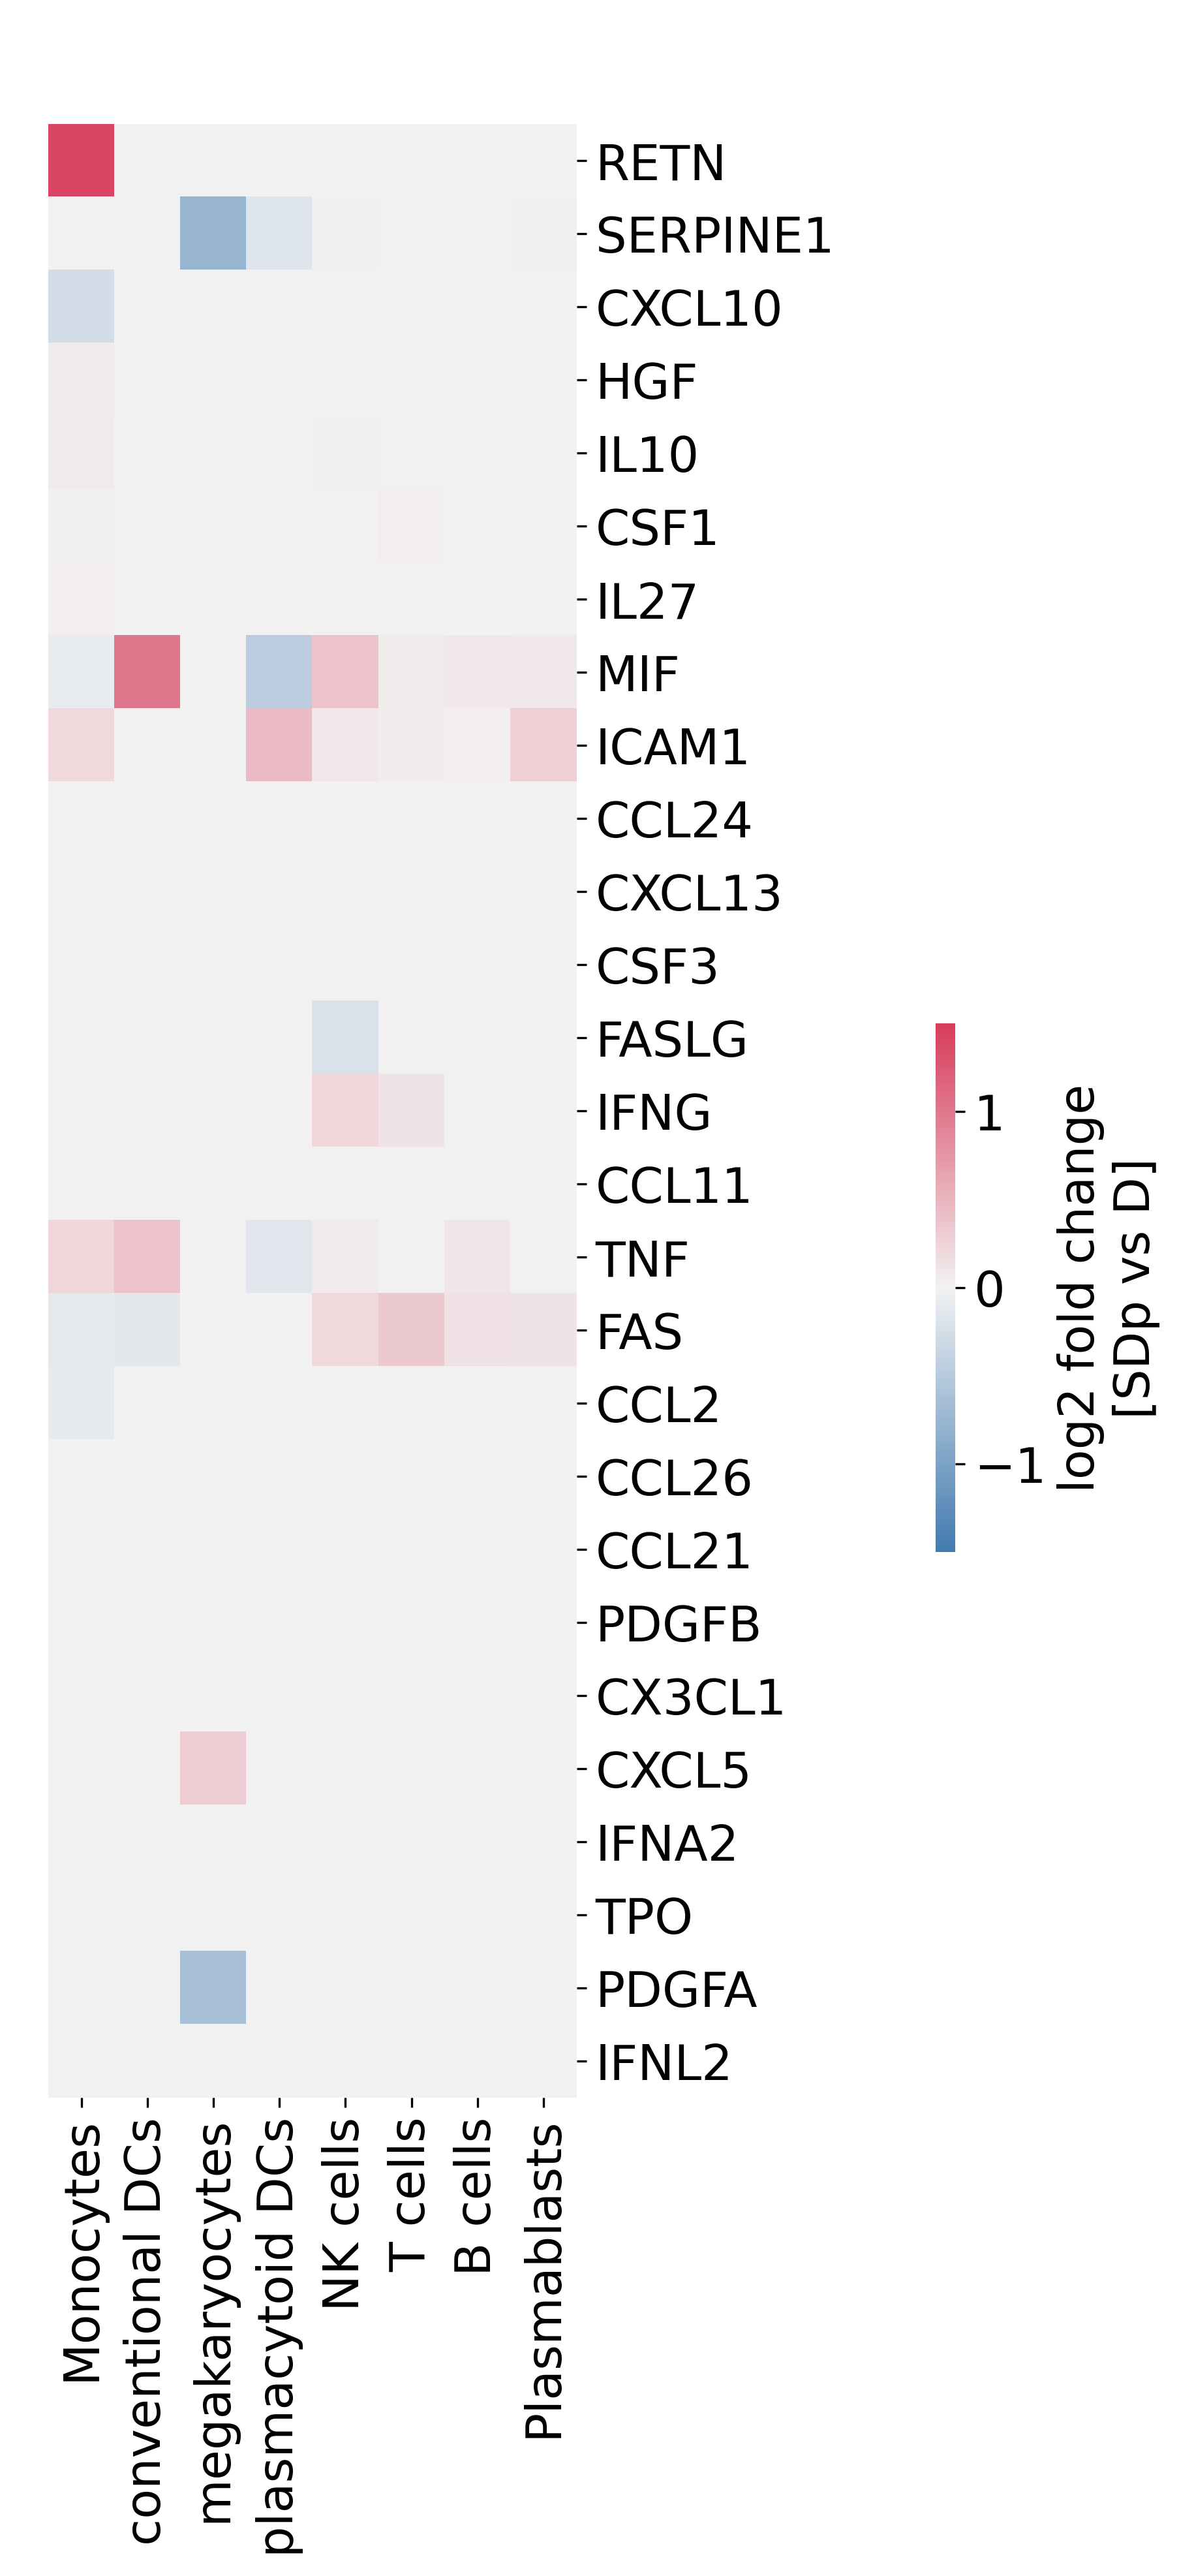

In [6]:
heatmap_cst(ct_pair, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            cts, vs_type='SDp vs D', save_fd='sig_cyto_dataset.png')
heatmap_cst(ct_pair, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            cts, vs_type='SDp vs D', save_fd='sig_cyto_dataset.pdf')

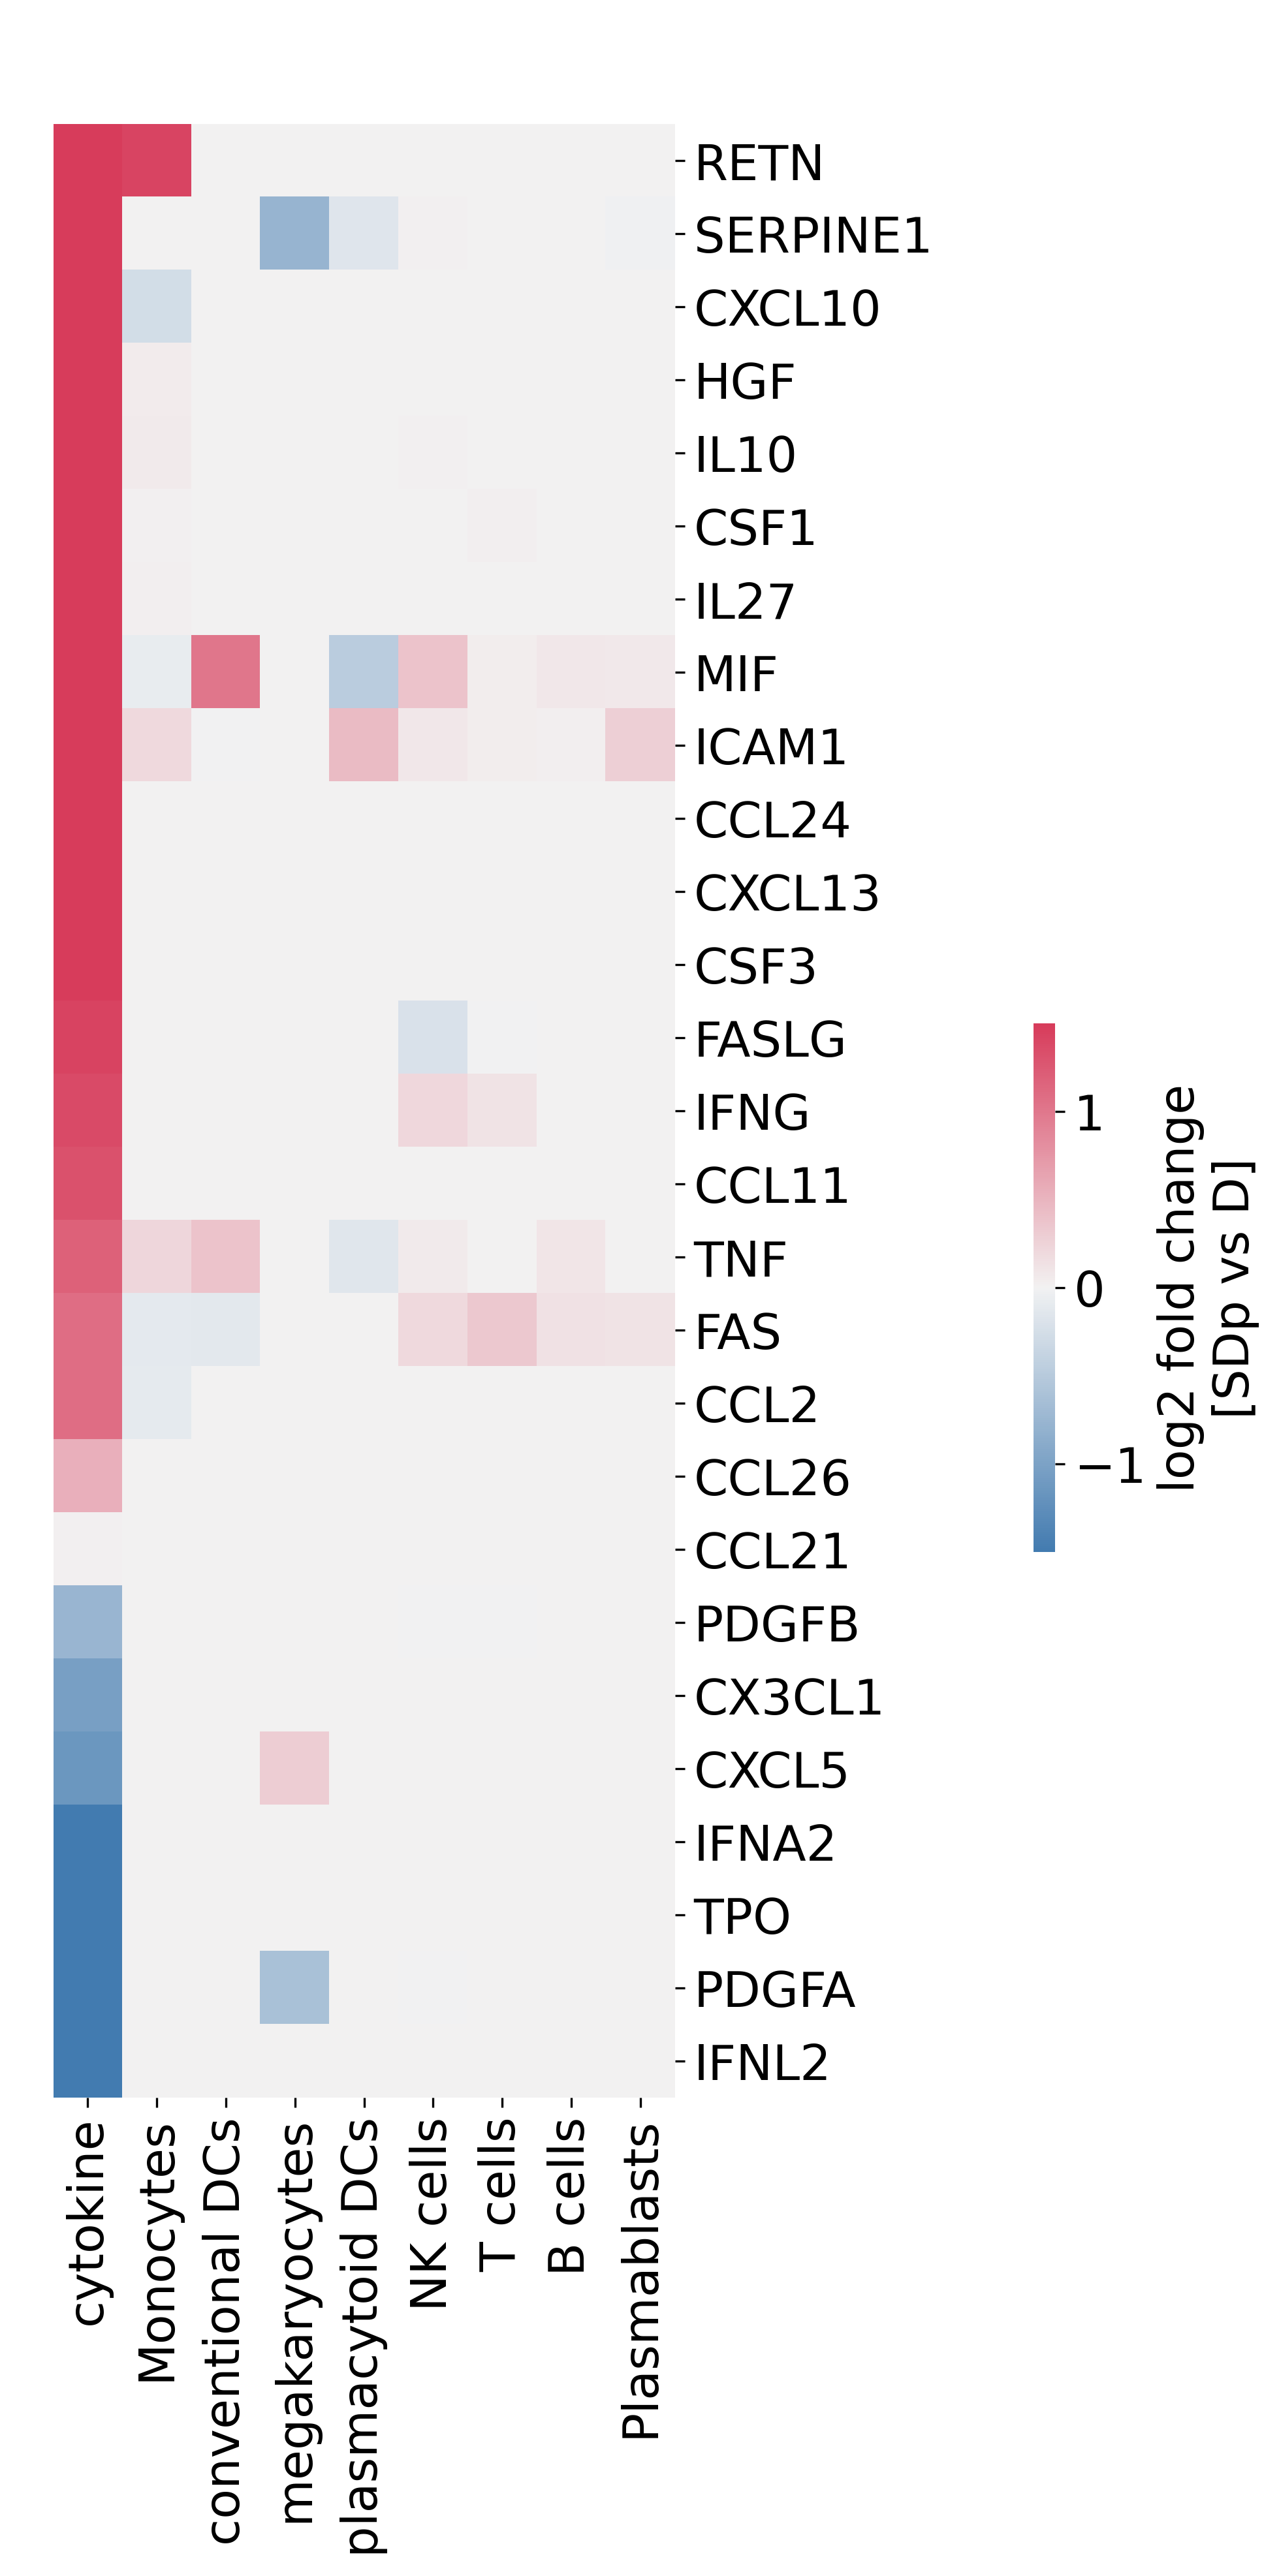

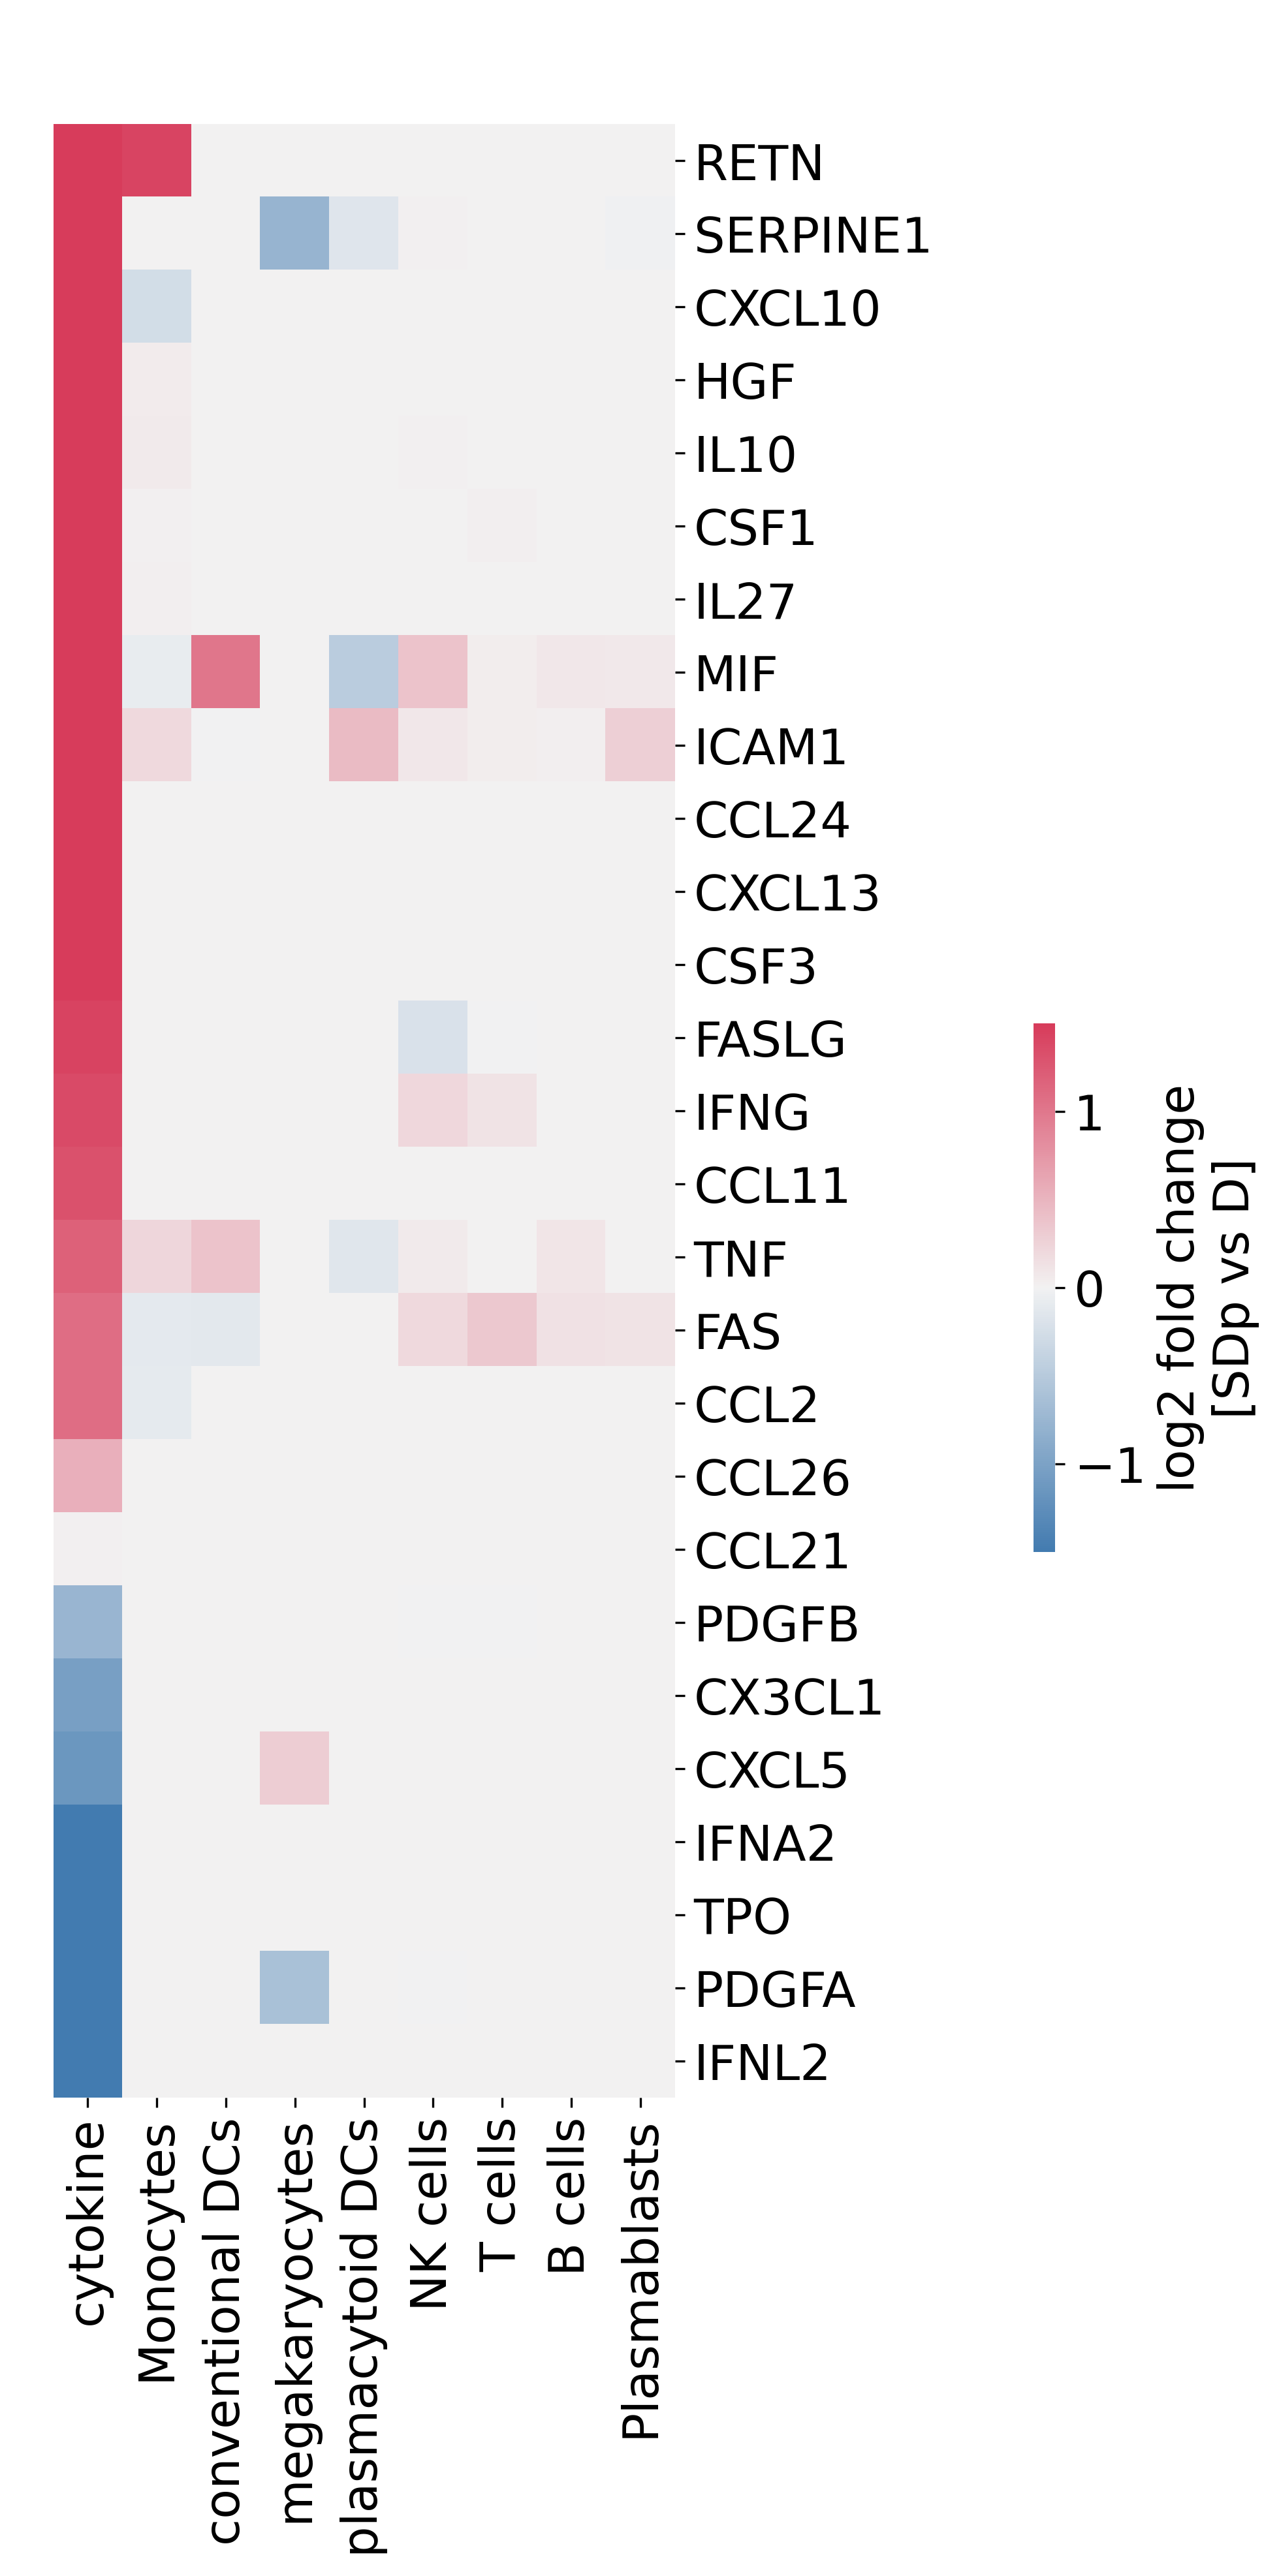

In [37]:
pair_mix = ct_pair[['med_pair']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
cyto_mix = pair[['med_pair']].reset_index()
pair_mix = pd.concat([pair_mix, cyto_mix])

heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, vs_type='SDp vs D', save_fd='sig_cyto_mix.png')
heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, vs_type='SDp vs D', save_fd='sig_cyto_mix.pdf')

In [85]:
def get_inters_med_pair(interactions, sig_cytos, cyto_pair, data_ct, cts, 
                        med_pair_cut_off, fra_pair_cut_off, fra_exp_cut_off):
    
    res = []
    for _, row in interactions.iterrows():
        lig = row['genesymbol_intercell_source'] # ligand
        rcp = row['genesymbol_intercell_target'] # receptor
        
        if lig in sig_cytos:
            ga = lig
            gb = rcp
            
        else:
            ga = rcp
            gb = lig
        
        for ct in cts:
            ct_med = data_ct.loc[ct, gb]['med_pair']
            ct_fra_pair = data_ct.loc[ct, gb]['fra_pair']
            ct_neg_fra_pair = data_ct.loc[ct, gb]['neg_fra_pair']
            ct_fra = {cd: data_ct.loc[ct, gb][cd + '_fra'] for cd in ['S', 'NS']}

            #####################
            if ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                (ct_med > med_pair_cut_off) & 
                (ct_fra['S'] > fra_exp_cut_off) & 
                (ct_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           data_ct.loc[ct, gb].tolist() + ['up'])

            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                  (ct_med < -med_pair_cut_off) & 
                  (ct_fra['NS'] > fra_exp_cut_off) & 
                  (ct_neg_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           data_ct.loc[ct, gb].tolist() + ['down'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                  (ct_med < -med_pair_cut_off) & 
                  (ct_fra['NS'] > fra_exp_cut_off) & 
                  (ct_neg_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           data_ct.loc[ct, gb].tolist() + ['mix'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                  (ct_med > med_pair_cut_off) & 
                  (ct_fra['S'] > fra_exp_cut_off) & 
                  (ct_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           data_ct.loc[ct, gb].tolist() + ['mix'])
  
    res = pd.DataFrame(res, columns = ['cytokine'] + [col + '_cyto' for col in pair.columns] + ['receptor', 'celltype'] + [col + '_rcp' for col in ct_pair.columns] + ['inter_type'])
    
    return res

In [77]:
cyto_inters = pd.read_csv('/home/yike/phd/dengue/data/sig_cytokine_interactions.tsv', sep='\t')
# cyto_inters = cyto_inters[cyto_inters['genesymbol_intercell_source'].isin(sig_cytos) |
#                           cyto_inters['genesymbol_intercell_target'].isin(sig_cytos)]

not_recp = ['CCR3', 'CCR4', 'CCR8', 'CXCR1', 'CXCR2', 'TNFRSF11B']
cyto_inters =  cyto_inters[(cyto_inters['genesymbol_intercell_source'].isin(sig_cytos)) & 
                           (~ cyto_inters['genesymbol_intercell_target'].isin(not_recp)) |
                           (~ cyto_inters['genesymbol_intercell_source'].isin(not_recp)) &
                           (cyto_inters['genesymbol_intercell_target'].isin(sig_cytos))
                          ]
cyto_pairs = cyto_inters[cyto_inters['genesymbol_intercell_source'].isin(ct_pair.loc['B cells'].index.unique()) &
                         cyto_inters['genesymbol_intercell_target'].isin(ct_pair.loc['B cells'].index.unique())]

In [86]:
res = get_inters_med_pair(cyto_inters, sig_cytos, pair, ct_pair, cts, 
                                0.8, 0, 39/56)

In [89]:
up = res[(res['med_pair_cyto'] > 0) & (res['med_pair_rcp'] >= 1) & 
         (res['fra_pair_rcp'] >= 39/56) & (res['S_fra_rcp'] >= 0.02)]

In [94]:
down = res[(res['med_pair_cyto'] < 0) & (res['med_pair_rcp'] <= -1) & 
         (res['neg_fra_pair_rcp'] >= 39/56) & (res['NS_fra_rcp'] >= 0.02)]

In [95]:
down

,cytokine,med_pair_cyto,fra_pair_cyto,neg_fra_pair_cyto,statistic_U_cyto,pvalue_U_cyto,avg_D_cyto,avg_SD_cyto,receptor,celltype,...,neg_fra_pair_rcp,S_fra_rcp,NS_fra_rcp,S_avg_rcp,NS_avg_rcp,log2_fold_change_rcp,statistic_rcp,pvalue_rcp,pvalue_corrected_rcp,inter_type
22,PDGFB,-0.752506,0.0,1.0,55.0,0.018129,14623.0425,8308.58,SPARC,megakaryocytes,...,0.75,0.727273,0.946429,244.346497,1113.600952,-2.183635,0.219156,0.116265,1.0,down


In [98]:
mix = res[((res['med_pair_cyto'] > 0) & (res['med_pair_rcp'] <= -1) & 
          (res['neg_fra_pair_rcp'] >= 39/56) & (res['NS_fra_rcp'] >= 0.02)) |
          ((res['med_pair_cyto'] < 0) & (res['med_pair_rcp'] >= 1) & 
          (res['fra_pair_rcp'] >= 39/56) & (res['S_fra_rcp'] >= 0.02))]

In [99]:
mix

,cytokine,med_pair_cyto,fra_pair_cyto,neg_fra_pair_cyto,statistic_U_cyto,pvalue_U_cyto,avg_D_cyto,avg_SD_cyto,receptor,celltype,...,neg_fra_pair_rcp,S_fra_rcp,NS_fra_rcp,S_avg_rcp,NS_avg_rcp,log2_fold_change_rcp,statistic_rcp,pvalue_rcp,pvalue_corrected_rcp,inter_type
23,TNF,1.194785,1.0,0.0,9.0,0.018129,215.25875,342.56875,ESAM,megakaryocytes,...,1.0,0.690909,0.785714,137.379364,271.603821,-0.978177,0.141883,0.577137,1.0,mix
